In [76]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<class 'ModuleNotFoundError'>: No module named 'seaborn'

### Data Assessment Stage

In [2]:
# Import the data
df = pd.read_csv('train.csv')
# Get a glimpse of the data
df.sample(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
5957,FDE29,NaN,Low Fat,0.142436,Frozen Foods,62.3878,OUT027,1985,Medium,Tier 3,Supermarket Type3,1514.6950
2836,FDQ59,9.80,Regular,0.056387,Breads,84.6908,OUT046,1997,Small,Tier 1,Supermarket Type1,503.3448
492,NCP42,8.51,Low Fat,0.016202,Household,195.2478,OUT017,2007,NaN,Tier 2,Supermarket Type1,4262.4516
7165,NCM43,NaN,Low Fat,0.034099,Others,162.6210,OUT019,1985,Small,Tier 1,Grocery Store,815.6050
6555,FDV43,16.00,Low Fat,0.077290,Fruits and Vegetables,44.5086,OUT017,2007,NaN,Tier 2,Supermarket Type1,713.7376


In [3]:
# Get the number of rows and columns
print(df.shape, '\n')
# Explore the data type and the existence of null values
print(df.info())

(8523, 12) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 566.0+ KB
None


In [4]:
# Get the unique values of the `Item_Fat_Content` column
df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [5]:
# Get a glimpse of the outlet types, size and average sales of each of them
df.groupby(['Outlet_Type', 'Outlet_Size'])['Item_Outlet_Sales'].mean()

Outlet_Type        Outlet_Size
Grocery Store      Small           340.329723
Supermarket Type1  High           2298.995256
                   Medium         2348.354635
                   Small          2358.343066
Supermarket Type2  Medium         1995.498739
Supermarket Type3  Medium         3694.038558
Name: Item_Outlet_Sales, dtype: float64

There seem to be no apparant correlation between `Outlet_Size` and `Item_Outlet_Sales`. So, we will depend on the `Outlet_Type` and `Outlet_Location_Type` columns in filling the null values in `Outlet_Size`

In [6]:
# We want to find the most redundant outlet_size value
df.groupby(['Outlet_Type', 'Outlet_Size'])['Outlet_Size'].count()

Outlet_Type        Outlet_Size
Grocery Store      Small           528
Supermarket Type1  High            932
                   Medium          930
                   Small          1860
Supermarket Type2  Medium          928
Supermarket Type3  Medium          935
Name: Outlet_Size, dtype: int64

#### From the result above,  All Grocery Stores seem to be small in size

In [7]:
# Find the null values in 'Outlet_Size' column and mirror it to the 'Outlet_Type' 
df[pd.isna(df['Outlet_Size'])].groupby(['Outlet_Type'])['Outlet_Type'].count()

Outlet_Type
Grocery Store         555
Supermarket Type1    1855
Name: Outlet_Type, dtype: int64

In [8]:
# Digging deep to find which 'Outlet_Location_Type' and 'Outlet_Identifier' have the null values
(df[pd.isna(df['Outlet_Size'])]).groupby(['Outlet_Type', 'Outlet_Location_Type'])['Outlet_Identifier'].count()

Outlet_Type        Outlet_Location_Type
Grocery Store      Tier 3                   555
Supermarket Type1  Tier 2                  1855
Name: Outlet_Identifier, dtype: int64

In [9]:
# Check if 'Outlet_Size' and 'Outlet_Location_Type' are related to 'Outlet_Type'
df.groupby(['Outlet_Type', 'Outlet_Location_Type', 'Outlet_Size'])['Outlet_Size'].count()

Outlet_Type        Outlet_Location_Type  Outlet_Size
Grocery Store      Tier 1                Small          528
Supermarket Type1  Tier 1                Medium         930
                                         Small          930
                   Tier 2                Small          930
                   Tier 3                High           932
Supermarket Type2  Tier 3                Medium         928
Supermarket Type3  Tier 3                Medium         935
Name: Outlet_Size, dtype: int64

From the result above,  All <b>Type1 Supermarkets</b> and in location <b>Tier 2</b> are having <b>small</b> size. So, we conclude that all null values in `Outlet_Size` column would be filled with <b>Small</b> value

<hr>

### Data Cleaning Stage

1. Fill the null values in the `Item_Weight` column with the average values of each `Item_Type`
2. Fill the null values in `Outlet_Size` with <b>Small</b> value
3. Change the type of `Item_Fat_Content` to <i> boolean</i> value

In [10]:
# Make a copy of our original dataframe to work on it
df_copy = df.copy()

`1.` Fill the null values in the `Item_Weight` column with the average values of each `Item_Type` 

In [11]:
df_copy['Item_Weight'] = df_copy.groupby('Item_Type')['Item_Weight'].transform(lambda x: x.fillna(x.mean()))

In [12]:
# Check for the existence of null values in `Item_Weight` column
df_copy['Item_Weight'].isna().sum()

0

`2.` Fill the null values in `Outlet_Size` with <b>Small</b> value

In [13]:
# Fill the null values in Outlet_Size column with Small value
df_copy['Outlet_Size'] = df_copy['Outlet_Size'].fillna('Small')

In [14]:
# Check the existence of null values
df_copy['Outlet_Size'].isna().sum()

0

`3.` Change the type of `Item_Fat_Content` to <i> boolean</i> value

In [15]:
# Give the value of 0 to 'low fat' values
df_copy['Item_Fat_Content'] = df_copy['Item_Fat_Content'].replace({'low fat': 0, 'LF': 0,'Low Fat': 0},
                                                                  regex=True)

In [16]:
# Change the type of `Item_Fat_Content` column to give True to 'Regular' values and False for 'Low Fat' values
df_copy['Item_Fat_Content'] = df_copy['Item_Fat_Content'].astype(bool)

In [17]:
# Validating data type
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   bool   
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: bool(1), float64(4), int64(1), object(6)
memory usage: 541.1+ KB


In [18]:
# Validating the count of each kind
# Count "low fat"
before = df.query("Item_Fat_Content == 'low fat' or Item_Fat_Content == 'LF' or Item_Fat_Content == 'Low Fat'")['Item_Fat_Content'].count()
# Count "False"
after = df_copy['Item_Fat_Content'].count() - df_copy['Item_Fat_Content'].sum()
# Compare
print(before == after)

True


<hr>

### Data Analysing Stage

1. What is the correlation number of established outlet(s) in each year and find the average sales in each year?
2. What is the location with highest level of sales?
3. What is the most successful size of outlets?
4. What is the prediction of sales in each location for each size of outlets?

##### 1. Find the number of established outlet(s) in each year and find the average sales in each year

In [19]:
# Find the number of established outlet(s) in each year
outlet_num = pd.DataFrame(df_copy.groupby('Outlet_Establishment_Year')['Outlet_Identifier'].count())
outlet_num

,Outlet_Identifier
Outlet_Establishment_Year,
1985,1463
1987,932
1997,930
1998,555
1999,930
2002,929
2004,930
2007,926
2009,928


In [20]:
# Find the average outlet sales each year
outlet_sales = pd.DataFrame(df_copy.groupby('Outlet_Establishment_Year')['Item_Outlet_Sales'].mean())
outlet_sales

,Item_Outlet_Sales
Outlet_Establishment_Year,
1985,2483.677474
1987,2298.995256
1997,2277.844267
1998,339.351662
1999,2348.354635
2002,2192.384798
2004,2438.841866
2007,2340.675263
2009,1995.498739


In [21]:
# Merging the two dataframes together to be easier in analysis
group = pd.concat([outlet_num, outlet_sales], axis=1)
group

,Outlet_Identifier,Item_Outlet_Sales
Outlet_Establishment_Year,,
1985,1463,2483.677474
1987,932,2298.995256
1997,930,2277.844267
1998,555,339.351662
1999,930,2348.354635
2002,929,2192.384798
2004,930,2438.841866
2007,926,2340.675263
2009,928,1995.498739


In [22]:
# Find the correlation between the number of outlets and the average level of sales
group['Outlet_Identifier'].corr(group['Item_Outlet_Sales'])

0.7067556231571772

In [23]:
# Plotting the data to figure out the possible relationship between the average sales and number of outlets
fig, ax = plt.subplots(1, 2, figsize=(12,6))

sns.lineplot(data = group, x = group.index, y = group['Outlet_Identifier'], sort = False, marker='o', ax = ax[0])
sns.barplot(data= group, x = group.index, y ='Item_Outlet_Sales', ax = ax[1])

ax[0].set_xlabel('Year')
ax[1].set_xlabel('Year')
ax[0].set_ylabel('Number of Outlets')
ax[1].set_ylabel('Average Sales')
ax[0].set_title('Number of established outlets (1985-2009)')
ax[1].set_title('Average sales of outlets (1985-2009)')

plt.show()

<class 'NameError'>: name 'sns' is not defined

A demonstrated in both graphs, the average sales tend to increase as the number of outlets increase. Additionally, the correlation between both variables seems to be high (around 0.71). So, We need to build a regression model to assure the possible amount of increase but the observations are not sufficient to build the model. 

##### 2. What is the location with highest level of sales?

In [24]:
# Get the average sales of each location
df_copy.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].mean()

Outlet_Location_Type
Tier 1    1876.909159
Tier 2    2323.990559
Tier 3    2279.627651
Name: Item_Outlet_Sales, dtype: float64

There seems the <b>'Tier 2'</b> location has the highest average level of sales

In [25]:
# Get the dummy variables of Outlet_Location_Type
df_copy[['Tier 1','Tier 2', 'Tier 3']] = pd.get_dummies(df_copy['Outlet_Location_Type'])

One of the variables is insignificant, but overall, the level of sales is predicted to be the greatest in <b>'Tier 2'</b> location, followed by <b>'Tier 3'</b>

##### 3. What is the most successful size of outlets?

In [27]:
# Get the average sales of each size
df_copy.groupby('Outlet_Size')['Item_Outlet_Sales'].mean()

Outlet_Size
High      2298.995256
Medium    2681.603542
Small     1867.182814
Name: Item_Outlet_Sales, dtype: float64

There seems the <b>'Medium'</b> size outlet is the most profitable

In [28]:
# Get the dummy variables of Outlet_Size
df_copy[['High','Medium', 'Small']] = pd.get_dummies(df_copy['Outlet_Size'])

Despite the low <b>R<sup>2</sup></b> of the model, our variables are significant. So, We can conclude that the predicted difference of the level of sales between <b>Medium and Large</b> outlet is around 2299 for the <b>Medium</b> size, holding all other variables constant. So, we can predict that the <b>Medium</b> size outlets are the most profitable.

##### 4. What is the prediction of sales in each location for each size of outlets?

In [30]:
# Get the average sales of each size in each location
df_copy.groupby(['Outlet_Size','Outlet_Location_Type'])['Item_Outlet_Sales'].mean()

Outlet_Size  Outlet_Location_Type
High         Tier 3                  2298.995256
Medium       Tier 1                  2348.354635
             Tier 3                  2847.959679
Small        Tier 1                  1576.192909
             Tier 2                  2323.990559
             Tier 3                   339.351662
Name: Item_Outlet_Sales, dtype: float64

We conclude that, <b>'Tier 1' and 'Tier 2'</b> have no<b> 'High'</b> size outlets. Additionally, <b>'Tier 2'</b> has no <b>'Medium'</b> size outlets

It seems all variables are significant, despite the low R<sup>2</sup>. So, we can predict that outlets with medium size will have higher sales than both small and high sizes by around 1518 and 321.6, respectively, holding all other variables constant. Additionally, we expect Tier 2 region will generate more revenues than both Tier 1 and Tier 3 by around 1038.3 and 1221.5, respectively, holding all other variables constant 

In [34]:
df_copy.sample(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Tier 1,Tier 2,Tier 3,intercept,High,Medium,Small
7479,DRI23,18.850000,False,0.137756,Hard Drinks,161.8578,OUT018,2009,Medium,Tier 3,Supermarket Type2,3530.0716,0,0,1,1,0,1,0
4908,FDO19,17.700000,True,0.016664,Fruits and Vegetables,47.9034,OUT018,2009,Medium,Tier 3,Supermarket Type2,729.0510,0,0,1,1,0,1,0
3889,FDP16,18.600000,False,0.065772,Frozen Foods,245.7802,OUT010,1998,Small,Tier 3,Grocery Store,245.6802,0,0,1,1,0,0,1
1397,NCZ17,13.142314,False,0.079047,Health and Hygiene,39.8506,OUT027,1985,Medium,Tier 3,Supermarket Type3,1480.0734,0,0,1,1,0,1,0
5716,NCP42,8.510000,False,0.016143,Household,194.2478,OUT045,2002,Small,Tier 2,Supermarket Type1,2324.9736,0,1,0,1,0,0,1


#### 5. Average Item Weight based on Type

In [57]:
avg_w = df_copy.groupby(['Item_Type'])['Item_Weight'].mean()
avg_w

Item_Type
Baking Goods             12.277108
Breads                   11.346936
Breakfast                12.768202
Canned                   12.305705
Dairy                    13.426069
Frozen Foods             12.867061
Fruits and Vegetables    13.224769
Hard Drinks              11.400328
Health and Hygiene       13.142314
Household                13.384736
Meat                     12.817344
Others                   13.853285
Seafood                  12.552843
Snack Foods              12.987880
Soft Drinks              11.847460
Starchy Foods            13.690731
Name: Item_Weight, dtype: float64

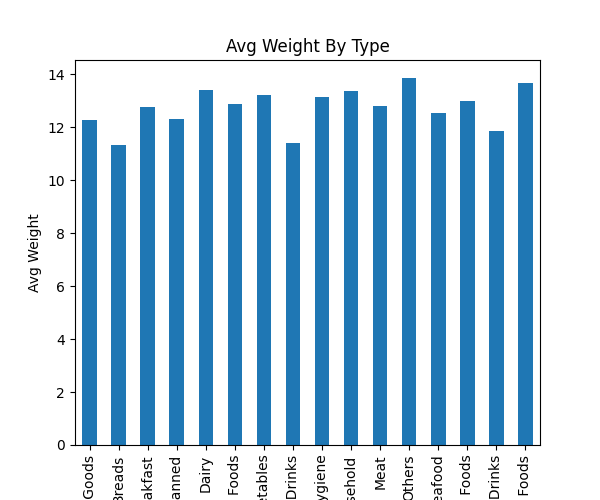

In [55]:
avg_w.plot(kind='bar', title='Avg Weight By Type', ylabel='Avg Weight',
         xlabel='Type')
plt.show()

***Observation:*** Apparently, average item width is consistent (Approx. ~12) regardless of the item type. This can help in outlet planning based on product types - these products are interchangeable and can be sold within the same outlets and transported with identical equipment.

#### W Effect of Item Visibility on Item Sales

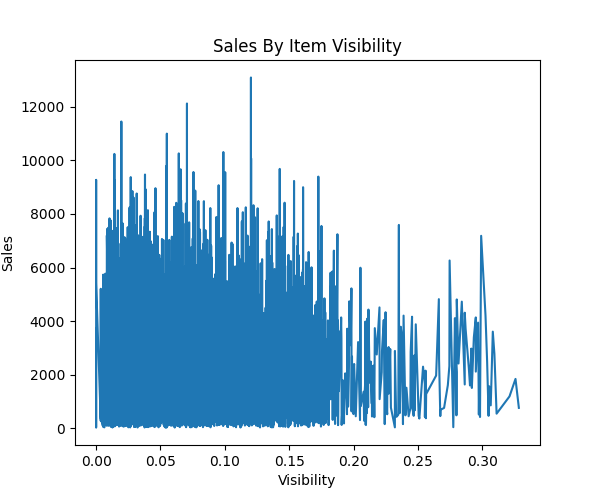

In [74]:
plt.plot(df_copy['Item_Visibility'].sort_values(), df_copy['Item_Outlet_Sales'])
plt.title("Sales By Item Visibility")
plt.xlabel("Visibility")
plt.ylabel("Sales")
plt.show()

***Observation:*** While counterintuitive, the data suggests that Visibility is inversely proportional with Sales. This can either mean that the current item visibility tactics are causing an opposite effect, or no effect on product success at all if this is a pure correlation.